In [1]:
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
import sys
from BayDS.lib.training import *

Using TensorFlow backend.
c:\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as

In [3]:
from catboost import CatBoostClassifier

In [4]:
df_train = pd.read_csv('data/onetwotrip_challenge_train.csv')
df_test = pd.read_csv('data/onetwotrip_challenge_test.csv')


In [5]:
df_train['orderid'] = df_train['orderid'] + 1000000

In [6]:
df_train = df_train.set_index('orderid')
df_test = df_test.set_index('orderid')

In [7]:
data = pd.concat([df_train, df_test], axis=0, sort=False )
data.fillna(-1,inplace=True)

In [8]:
data.head()

,userid,field0,field1,field2,field3,field4,field5,field6,field7,field8,...,indicator_goal22,indicator_goal23,indicator_goal24,indicator_goal25,goal21,goal22,goal23,goal24,goal25,goal1
orderid,,,,,,,,,,,,,,,,,,,,,
1000000,10d654494cbe97bbb25d51ead2600679aff9e097924add...,0,-0.626508119430350,11,12,1,1,0,1,1,...,1,0,1,1,0.0,1.0,0.0,0.0,0.0,0.0
1000001,4aafc0391f72bbcf60537aece62923baf9ce644b64ac36...,144,-0.393794036775907,5,7,2,0,0,2,1,...,1,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0
1000002,bac8ffef46348f587c8d17137ab01fb24aef21547c647d...,134,-0.548936758545536,2,3,2,0,0,1,1,...,1,0,1,1,0.0,0.0,0.0,0.0,0.0,0.0
1000003,0392247b4b87674aba2c32bf2292b105771a6a376871be...,0,-0.238651315006278,10,11,1,1,3,2,1,...,1,0,1,1,0.0,0.0,0.0,0.0,0.0,0.0
1000004,d1aeefef311bbeb4bd84876c8d49421f276674527d5578...,0,-0.704079480315165,8,11,1,1,0,1,1,...,1,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
data.columns

Index(['userid', 'field0', 'field1', 'field2', 'field3', 'field4', 'field5',
       'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field12',
       'field13', 'field14', 'field15', 'field16', 'field17', 'field18',
       'field19', 'field20', 'field21', 'field22', 'field23', 'field24',
       'field25', 'field26', 'field27', 'field28', 'field29',
       'indicator_goal21', 'indicator_goal22', 'indicator_goal23',
       'indicator_goal24', 'indicator_goal25', 'goal21', 'goal22', 'goal23',
       'goal24', 'goal25', 'goal1'],
      dtype='object')

# Feature engineering

In [46]:
new_features=[]

In [10]:
data['paid_tickets'] = data.field15 - data.field9

In [47]:
price_field = 'field1'
price2_field = 'field14'
data['price1'] = data[price_field]  /0.077571
data['price2'] = data[price2_field]  /0.140066

In [48]:
data['multiplied_price2'] = data['price2']*data['field15']
new_features.append('multiplied_price2')

In [49]:
data['price1_to_multiplied_price2'] = data['price1'] / (data['price2']*data['field15'])
new_features.append('price1_to_multiplied_price2')

In [50]:
data.index

Int64Index([1000000, 1000001, 1000002, 1000003, 1000004, 1000005, 1000006,
            1000007, 1000008, 1000009,
            ...
             455001,  455002,  455003,  455004,  455005,  455006,  455007,
             455008,  455009,  455010],
           dtype='int64', name='orderid', length=651067)

In [65]:
data = pd.merge(data.reset_index(), data.groupby('userid')['field0'].agg(['count']), on='userid', how='left').set_index('orderid')
new_features.append('count')

In [55]:
data = pd.merge(data.reset_index(), data.groupby('userid')['price1'].agg(['mean','std']), on='userid').rename(columns={'mean':'price1_to_userid_mean','std':'price1_to_userid_std'})
data = pd.merge(data, data.groupby('userid')['price2'].agg(['mean','std']), on='userid').rename(columns={'mean':'price2_to_userid_mean','std':'price2_to_userid_std'})
data=data.set_index('orderid')

In [58]:
data['field2_diff_field3'] = data['field2']-data['field3']
new_features.append('field2_diff_field3')

In [68]:
new_features = ['multiplied_price2',
 'price1_to_multiplied_price2',
 'count',
 'field2_diff_field3',
               'price1_to_userid_mean',
               'price1_to_userid_std',
               'price2_to_userid_mean',
               'price2_to_userid_std']

In [69]:
new_features

['multiplied_price2',
 'price1_to_multiplied_price2',
 'count',
 'field2_diff_field3',
 'price1_to_userid_mean',
 'price1_to_userid_std',
 'price2_to_userid_mean',
 'price2_to_userid_std']

# Training

In [70]:
X = data[data['goal1']>=0].drop(['goal1'], axis=1)
y = data[data['goal1']>=0]['goal1']
all_features = [f'field{i}' for i in range(30)] + new_features
test=data[data['goal1']<0]

In [71]:
from sklearn.model_selection import GroupKFold, KFold

NFOLDS = 5
folds = GroupKFold(n_splits=NFOLDS)
params = {
          'objective': 'binary',
          "metric": 'auc',
          "verbosity": -1,
         }
train_options = {
        "model_type":'lgb',
        "params": params,
        "eval_metric":'auc',
        'early_stopping_rounds': 100,
        'n_estimators': 500,
        'averaging': 'rank',
        'use_groups': False,
        'fold_name': folds.__class__.__name__,
        'n_splits': NFOLDS
    }

Fold 1 started at Wed Dec  4 23:46:44 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.853857	training's auc: 0.853857	valid_1's auc: 0.660577	valid_1's auc: 0.660577
Early stopping, best iteration is:
[26]	training's auc: 0.762285	training's auc: 0.762285	valid_1's auc: 0.669684	valid_1's auc: 0.669684
Fold 2 started at Wed Dec  4 23:46:54 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.853638	training's auc: 0.853638	valid_1's auc: 0.700316	valid_1's auc: 0.700316
Early stopping, best iteration is:
[37]	training's auc: 0.777797	training's auc: 0.777797	valid_1's auc: 0.714242	valid_1's auc: 0.714241
Fold 3 started at Wed Dec  4 23:47:04 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.853335	training's auc: 0.853335	valid_1's auc: 0.686553	valid_1's auc: 0.686553
Early stopping, best iteration is:
[98]	training's auc: 0.849861	training's auc: 0.849861	vali

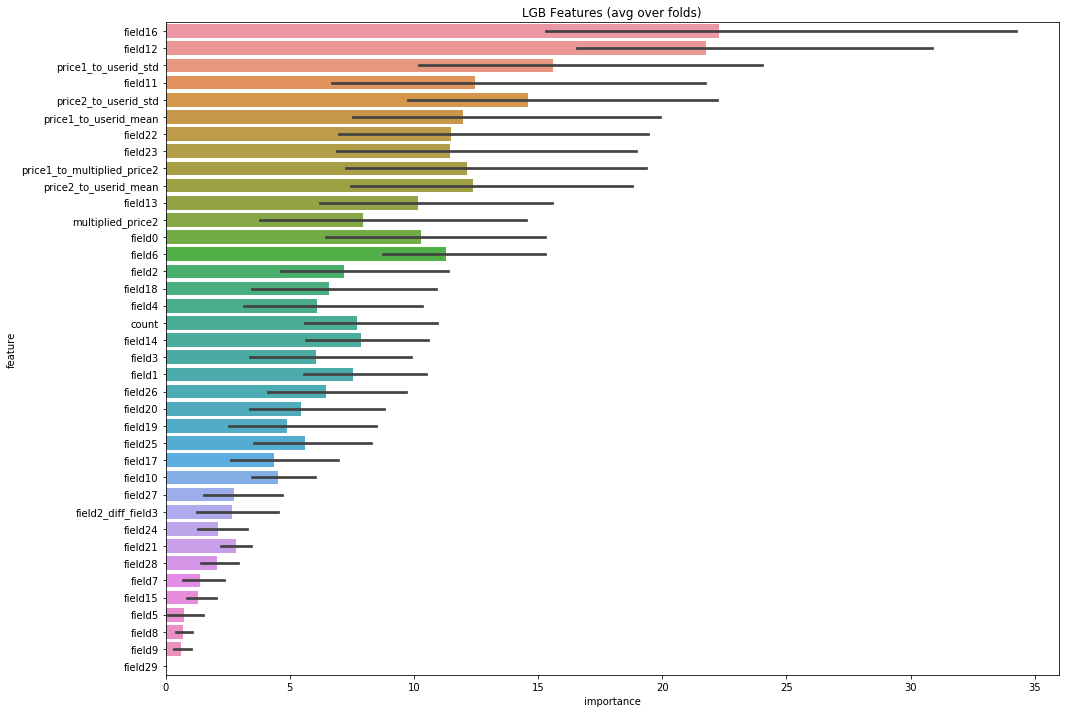

In [72]:
result_dict = train_model_classification_vb( X=X, 
                                             X_test=test, 
                                             columns=all_features,
                                             y=y, 
                                             params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             groups=X['userid'],
                                             n_jobs=-1)

In [ ]:
result_dict = train_model_classification_vb( X=X, 
                                             X_test=test, 
                                             columns=all_features,
                                             y=y, 
                                             params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             groups=X['userid'],
                                             n_jobs=-1)

In [ ]:
result_dict = train_model_classification_vb( X=X, 
                                             X_test=test, 
                                             columns=all_features,
                                             y=y, 
                                             params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             groups=X['userid'],
                                             n_jobs=-1)

In [ ]:
result_dict = train_model_classification_vb( X=X, 
                                             X_test=test, 
                                             columns=all_features,
                                             y=y, 
                                             params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             n_jobs=-1)

In [ ]:
result_dict = train_model_classification_vb( X=X, 
                                             X_test=test, 
                                             columns=all_features,
                                             y=y, 
                                             params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             n_jobs=-1)

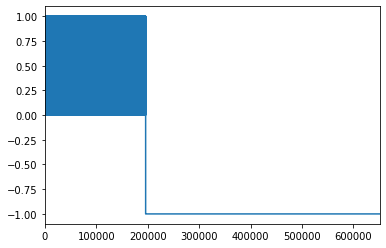

In [36]:
data.goal1.plot()

In [73]:
test['proba'] = result_dict['prediction']

In [74]:
sub = pd.read_csv('data/onetwotrip_challenge_sub1.csv')

In [75]:
sub['proba'] = test['proba'] / test['proba'].max()

In [76]:
sub

,orderid,proba
0,0,0.157876782034864
1,1,0.157880298955870
2,2,0.826992544567082
3,3,0.753149952279778
4,4,0.040589224945345
5,5,0.248116139282381
6,6,0.418700436142166
7,7,0.345720588539146
8,8,0.720057264266280
9,9,0.372909685028951


In [77]:
sub.reset_index(drop=True).set_index('orderid').to_csv('submissions/0412_last.csv')